## Exploring Time Series With Transformers

In [1]:
# Configuration-driven universal setup cell (v2: supports project + shared src/)
import os
import sys
from pathlib import Path

# Fix OpenMP issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Centralized import config
# Format: {'relative_path_to_root_or_src': ['func1', 'func2']}
# Use None key for modules directly under the notebook's project root
IMPORT_CONFIG = {
    '../../src': ['plot_style'],                # shared across projects
    '.': ['models', 'data'],                    # project-local packages (optional)
}

def setup_imports():
    """Setup imports using relative paths and fallback strategies."""
    imported_modules = {}

    # Determine notebook directory as reference point
    notebook_dir = Path().resolve()  # CWD in notebook = its directory

    for rel_path, module_names in IMPORT_CONFIG.items():
        if rel_path == '.':
            search_path = notebook_dir
        else:
            search_path = (notebook_dir / rel_path).resolve()

        if not search_path.exists():
            print(f"Path not found: {search_path}")
            continue

        # Add to sys.path if not already present
        str_path = str(search_path)
        if str_path not in sys.path:
            sys.path.insert(0, str_path)

        # Import each module
        for mod_name in module_names:
            try:
                mod = __import__(mod_name)
                imported_modules[mod_name] = mod
                print(f"Imported '{mod_name}' from {search_path}")
            except ImportError as e:
                print(f"Failed to import '{mod_name}' from {search_path}: {e}")

    if not imported_modules:
        raise ImportError("No modules could be imported from configured paths.")

    return imported_modules

# Execute setup
try:
    imports = setup_imports()
    globals().update(imports)  # e.g., plot_style, models, data now available
    print("All imports ready")
except Exception as e:
    print(f"Import setup failed: {e}")
    raise

Imported 'plot_style' from /datasets/_deepnote_work/generative-models-journey/src
Imported 'models' from /datasets/_deepnote_work/generative-models-journey/projects/vqvae-transformer-ts
Imported 'data' from /datasets/_deepnote_work/generative-models-journey/projects/vqvae-transformer-ts
All imports ready


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Access shared style
from plot_style import colors

# Access local project code
from data.generate_synthetic import generate_dataset
from models.vqvae import VQVAETimeSeries
from models.transformer import TimeSeriesTransformer

from train_vqvae import train_model as train_vqvae


from sklearn.preprocessing import StandardScaler
#import pickle

import matplotlib.pyplot as plt

np.random.seed(42)

Goal: Learn a generative model for short multivariate time series using:

- A small VQ-VAE to compress sequences into discrete tokens.
- A minimal Transformer to model token sequences autoregressively.

### Data

We will be using short multivariate sequences $x \in \mathbb{R}^{T \times D}$, $T=16$, $D=3$. 
They will mimic key behaviors in financial data sets:
 - Regime shifts (calm vs volatile)
 - Trends and mean reversion
 - Noise with structure

Each sequence belongs to one of three types:

| Type | Description |  
|---|---|
| 1. Trending | Slow linear drift + low noise |  
|2. Mean-Reverting| Oscillates around zero, like OU process|
|3. Volatile Spike| Mostly flat, then sudden spike in middle|




In [3]:
results = generate_dataset(n_per_class = 3000)
data = results['data']
label = results['labels']
print(f"Data shape: {data.shape}")  # (9000, 16, 3)

Data shape: (9000, 16, 3)


Normalizing the data.

In [4]:
N, T, D = data.shape
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(N, -1)).reshape(N, T, D).astype(np.float32)

# Clip extremes
data = np.clip(data, -5.0, 5.0).astype(np.float32)

In [5]:
print("Data mean:", data.mean())
print("Data std:", data.std())
print("Min:", data.min(), "Max:", data.max())

Data mean: -0.00089050207
Data std: 0.99461687
Min: -4.790724 Max: 5.0


### Phase 1: "Tokenization" for Time Series

In time series tokenization means compressing a time window into a short sequence of discrete symbols ("codes"). We will use a VQ-VAE as our tokenizer.

It learns:

- An encoder that maps input to continuous latent
- A codebook that discretizes latent to nearest code
- A decoder that reconstructs from codes

```
Raw Time Series ──[Encoder]──→ z_e ──[Nearest Code]──→ c₁,c₂,... ──[Decoder]──→ Reconstructed
```
The sequence $\{c_n\}$ is the desired tokenized representation.

#### Model Architecture (Not accurate - changing during development)
```
Input (16,3)
   ↓ Flatten → 48
   ↓ Linear → 128
   ↓ ReLU
   ↓ Linear → 32 (→ reshape to L=2, K=16) ← z_e (continuous latent)
   ↓
[VQ Layer] → finds closest code in codebook (64 codes, dim=16)
   ↓ z_q (quantized, shape [B,4,16])
   ↓ Reshape → 32
   ↓ Linear → 128
   ↓ ReLU
   ↓ Linear → 48
   ↓ Reshape → (16,3)
Output (reconstruction)
```

### Training

Loss has two parts:

- Reconstruction loss: MSE between input and output
- VQ loss: commitment loss (stabilizes training)


In [6]:
DEBUG=False

n_codes = 64
code_dim = 16
n_tokens = 4


In [7]:
if(DEBUG): #see what's going on with the model
    X = torch.tensor(data, dtype=torch.float32)

    print("X dtype:", X.dtype)
    print("X min:", X.min().item(), "X max:", X.max().item())
    print("X mean:", X.mean().item(), "X std:", X.std().item())


    model = VQVAETimeSeries(n_codes=n_codes, code_dim=code_dim, n_tokens=n_tokens)

    with torch.no_grad():
        z_e_sample = model.encode(X[:10])
        print("Latent std after norm:", z_e_sample.std().item())  # should be ~0.5-1.0
        model.vq_layer.codebook.weight.normal_(0, z_e_sample.std().item())

    model.eval()  # disable dropout if there is any

    with torch.no_grad():
        test_input = X[:2]  # 2 samples
        print("Input shape:", test_input.shape)
        print("Input range:", test_input.min().item(), test_input.max().item())
    
        recon, z_q, indices = model(test_input)
        print("Recon range:", recon.min().item(), recon.max().item())
        print("Recon shape:", recon.shape)
    
        mse = F.mse_loss(recon, test_input)
        print("Initial MSE:", mse.item())

        z_e = model.encode(test_input)
        print("z_e range:", z_e.min().item(), z_e.max().item())
        print("z_e std:", z_e.std().item())

In [8]:
n_epochs = 50
batch_size = 64
beta = 0.01  # commitment weight
learning_rate = 1e-3

In [9]:

model, history = train_vqvae(
    training_data = data,
    n_codes=n_codes,
    code_dim=code_dim,
    n_tokens=n_tokens,    
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    beta=beta,
    device='cpu',
    checkpoint_interval=10,
    debug=True,
    pth_path="vqvae.pth"
    )


Starting training on cpu...
Epochs: 50, Batch size: 64
Before for loop: 0
 loss item:1.8815455436706543
 loss item:1.8740155696868896
 loss item:1.9327110052108765
 loss item:1.8826212882995605
 loss item:1.8964215517044067
 loss item:1.9250199794769287
 loss item:1.9732109308242798
 loss item:1.924236536026001
 loss item:1.948505163192749
 loss item:1.992711067199707
 loss item:2.011274814605713
 loss item:1.9361863136291504
 loss item:1.9558634757995605
 loss item:2.0423529148101807
 loss item:2.0382323265075684
 loss item:2.038437604904175
 loss item:2.0689961910247803
 loss item:2.0152454376220703
 loss item:2.0053038597106934
 loss item:2.0812411308288574
 loss item:2.106959819793701
 loss item:2.1087520122528076
 loss item:2.0647165775299072
 loss item:2.116778612136841
 loss item:2.1517367362976074
 loss item:2.065112590789795
 loss item:2.100649118423462
 loss item:2.0991196632385254
 loss item:2.1236631870269775
 loss item:2.0385048389434814
 loss item:2.1571083068847656
 loss

KeyboardInterrupt: 

#### Model Diagnostics

In [10]:
# Diagnostic: Check z_e vs z_q
model.eval()  # set to evaluation mode (no dropout, etc.)
with torch.no_grad():  # disable gradient computation
    # Take a small batch (e.g., first 5 samples)
    batch = X[:5]  # shape: [5, 16, 3]
    
    # Get continuous latent from encoder
    z_e = model.encode(batch)  # shape: [5, n_tokens, code_dim]
    
    # Quantize it
    z_q, indices = model.vq_layer(z_e)  # z_q: [5, n_tokens, code_dim]
    
    # Print stats
    print("z_e std:", z_e.std().item())
    print("z_q std:", z_q.std().item())
    print("z_e mean:", z_e.mean().item())
    print("z_q mean:", z_q.mean().item())
    
    # Are they similar? (should be close if VQ works)
    diff = (z_e - z_q).abs().mean().item()
    print(f"Mean |z_e - z_q|: {diff:.4f}")

NameError: name 'model' is not defined

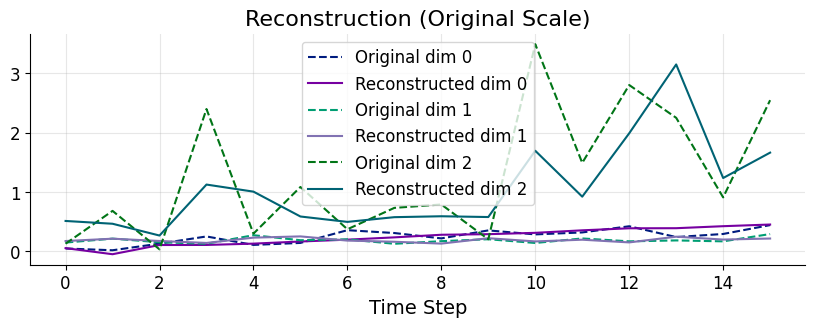

In [14]:
# Reconstruct
recon = model.decode(z_q)

# Inverse transform for meaningful plotting
orig_plot = scaler.inverse_transform(batch.reshape(-1, 48)).reshape(-1, 16, 3)
recon_plot = scaler.inverse_transform(recon.detach().numpy().reshape(-1, 48)).reshape(-1, 16, 3)

# Plot first sample
plt.figure(figsize=(10, 3))
for d in range(3):
    plt.plot(orig_plot[0, :, d], '--', label=f'Original dim {d}')
    plt.plot(recon_plot[0, :, d], '-', label=f'Reconstructed dim {d}')
plt.legend()
plt.title("Reconstruction (Original Scale)")
plt.xlabel("Time Step")
plt.grid(True, alpha=0.3)
plt.show()

Used 64 / 64 codes


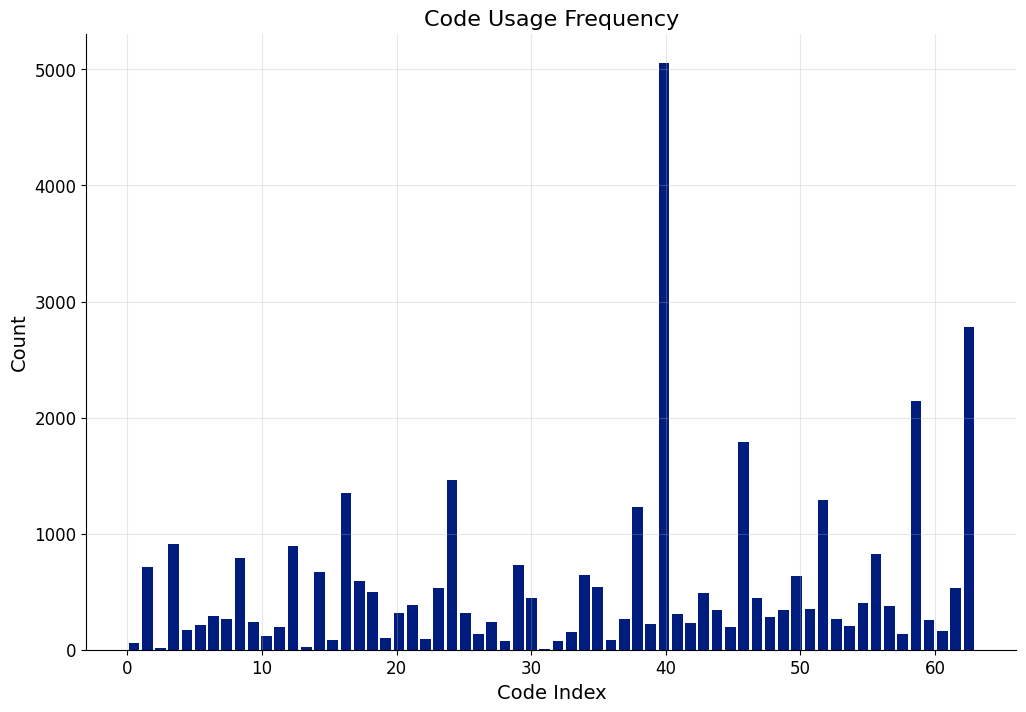

In [15]:
with torch.no_grad():
    _, _, indices = model(X)
    unique_codes = torch.unique(indices).numel()
    print(f"Used {unique_codes} / 64 codes")
    
    # Plot histogram of code usage
    plt.hist(indices.numpy().flatten(), bins=64, rwidth=0.8)
    plt.title("Code Usage Frequency")
    plt.xlabel("Code Index")
    plt.ylabel("Count")
    plt.show()

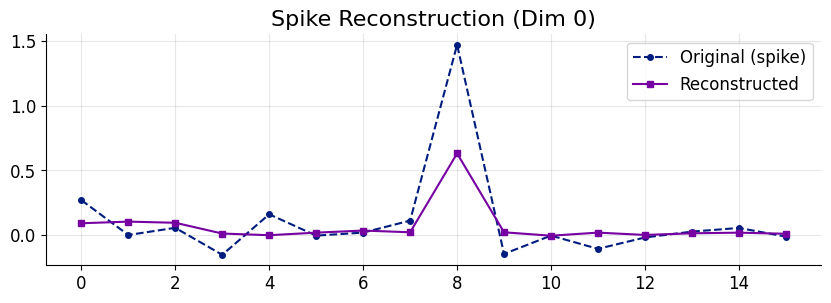

In [16]:
# Find a spike sample
spike_idx = np.where(labels == 2)[0][0]  # class 2 = spike
orig = X[spike_idx:spike_idx+1]
recon, _, _ = model(orig)

# Inverse transform
orig_plot = scaler.inverse_transform(orig.reshape(1, -1)).reshape(16, 3)
recon_plot = scaler.inverse_transform(recon.detach().numpy().reshape(1, -1)).reshape(16, 3)

plt.figure(figsize=(10, 3))
plt.plot(orig_plot[:, 0], 'o--', label='Original (spike)', markersize=4)
plt.plot(recon_plot[:, 0], 's-', label='Reconstructed', markersize=4)
plt.legend(); plt.title("Spike Reconstruction (Dim 0)")
plt.show()

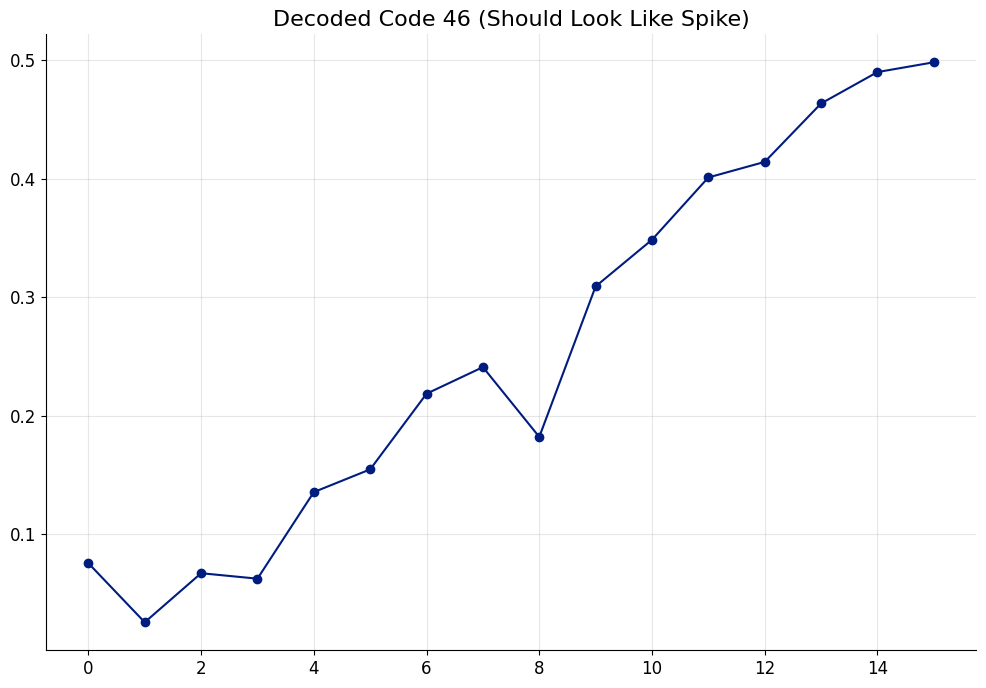

In [17]:
# Pick a code that appears in spike samples
spike_code = indices[labels == 2][0][0].item()  # first spike sample's code

# Create a batch of just this code
z_q = model.vq_layer.codebook.weight[spike_code].unsqueeze(0).unsqueeze(0)  # [1, 1, code_dim]
if n_tokens > 1:
    z_q = z_q.repeat(1, n_tokens, 1)  # or use realistic token sequence

recon = model.decode(z_q)

# Plot
recon_plot = scaler.inverse_transform(recon.detach().numpy().reshape(1, -1)).reshape(16, 3)
plt.plot(recon_plot[:, 0], 'o-')
plt.title(f"Decoded Code {spike_code} (Should Look Like Spike)")
plt.show()

### Transformer Prior

#### Training

First, prepare the data using our tokenizer.

In [19]:
# train_prior.py
#from vqvae import VQVAETimeSeries  
#from transformer import TimeSeriesTransformer

import copy

# Load your trained VQ-VAE
vqvae = copy.deepcopy(model) #VQVAETimeSeries(n_codes=64, code_dim=16, n_tokens=4)
#vqvae.load_state_dict(torch.load("vqvae.pth"))
vqvae.eval()

# Extract tokens for all data
with torch.no_grad():
    _, _, indices = vqvae(X)  # X: [N, 16, 3] → indices: [N, 4]

# Convert to long tensor
token_dataset = indices.long()  # [N, 4]
print("Token dataset shape:", token_dataset.shape)

Token dataset shape: torch.Size([9000, 4])


#### The Training Loop

In [20]:
# Train the Transformer prior
from train_transformer import train_model as train_transformer

model, history = train_transformer(
    token_dataset,
    n_codes=64,
    n_tokens=4,
    d_model=32,
    n_heads=2,
    n_layers=2
    n_epochs=50,
    batch_size=128,
    learning_rate=3e-4,
    beta = 0.01,
    device='cpu',
    checkpoint_interval=10,
    debug=False,
    pth_path="transformer.pth" 
)


Epoch 0, Loss: 278.6789
Epoch 10, Loss: 118.9892
Epoch 20, Loss: 96.8821
Epoch 30, Loss: 91.9586
Epoch 40, Loss: 89.9981
Training complete!


#### Sampling New Sequences

In [24]:
from sample import sample_sequence

# Generate 5 new token sequences
model.eval()
generated_tokens = []
for _ in range(5):
    tokens = sample_sequence(model, temperature=1.0)
    generated_tokens.append(tokens)

print("Generated tokens:", generated_tokens)

Generated tokens: [tensor([45, 39, 50, 17]), tensor([ 9, 54, 24, 35]), tensor([26,  4, 13, 54]), tensor([ 0, 31, 45, 35]), tensor([ 2, 17, 25,  6])]


#### Decode to Time Series

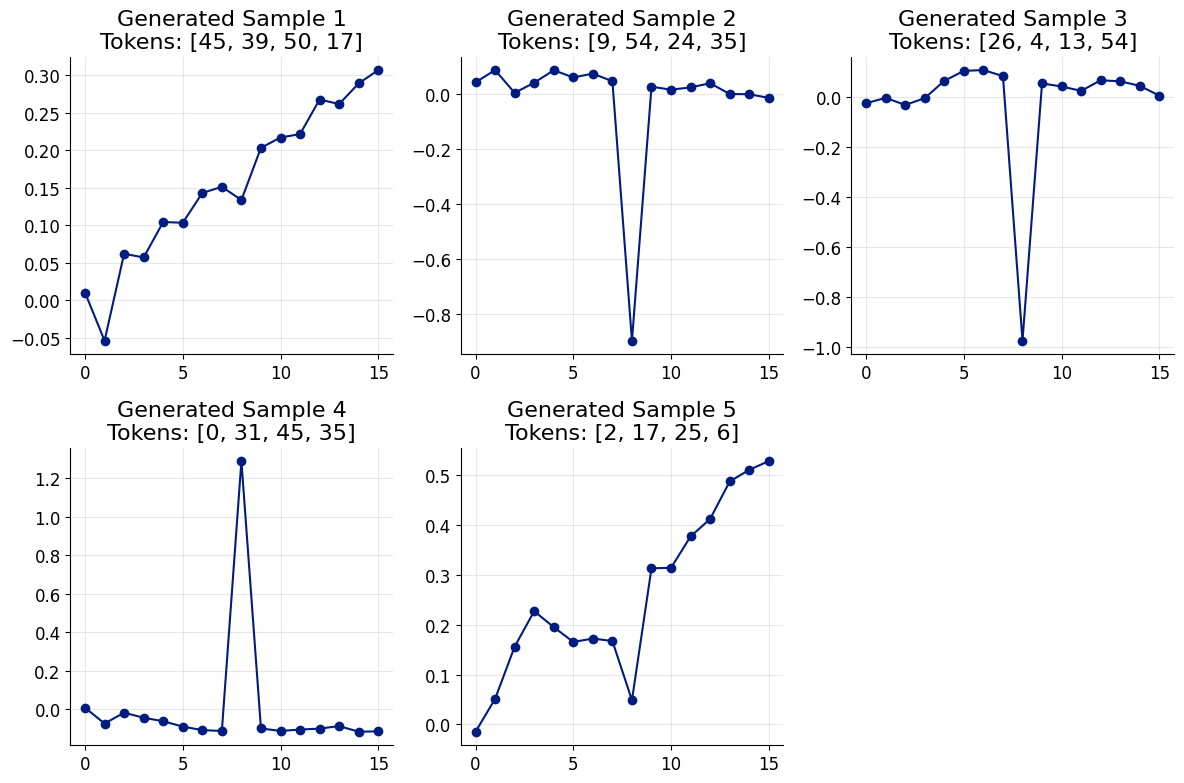

In [27]:
# Decode tokens back to time series
def tokens_to_time_series(tokens, vqvae):
    with torch.no_grad():
        # tokens: [4] → [1, 4]
        z_q = vqvae.vq_layer.codebook(tokens.unsqueeze(0))  # [1, 4, 16]
        recon = vqvae.decode(z_q)  # [1, 16, 3]
        return recon.squeeze(0).numpy()

# Plot generated samples
plt.figure(figsize=(12, 8))
for i, tokens in enumerate(generated_tokens):
    ts = tokens_to_time_series(tokens, vqvae)
    ts_orig = scaler.inverse_transform(ts.reshape(1, -1)).reshape(16, 3)
    
    plt.subplot(2, 3, i+1)
    plt.plot(ts_orig[:, 0], 'o-')
    plt.title(f"Generated Sample {i+1}\nTokens: {tokens.tolist()}")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("generated_samples.png")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de7d40e8-6998-4e65-8626-6720908f4576' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>